In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [3]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [8]:
%%R

# My commonly used R imports

require('tidyverse')
library(dplyr)
library(lubridate)
library(ggbump)
library(ggbeeswarm)

R[write to console]: Loading required package: timechange

R[write to console]: 
Attaching package: ‘lubridate’


R[write to console]: The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




# Import snow and salt data

In [5]:
%%R
 
# Import data with R
salt <- read_csv('./data/DSNY_Salt_Usage.csv', show_col_types = FALSE)
salt$`Date of Report` <- as.Date(salt$`Date of Report`, format = "%m/%d/%Y")
salt %>% head(4)

# A tibble: 4 × 8
  `DSNY Storm #` `Date of Report` Manhattan Bronx Brook…¹ Queens State…² Total…³
  <chr>          <date>               <dbl> <dbl>   <dbl>  <dbl>   <dbl>   <dbl>
1 Storm 1        2016-01-19            1111  2059    2690   6625    2931   15416
2 Storm 2        2016-01-23            2919  4567    5521   9253    4264   26524
3 Storm 2        2016-01-24            6582  8167   12290  17133    5411   49583
4 Storm 2        2016-01-25            3862  4094    6217  10236    1256   25665
# … with abbreviated variable names ¹​Brooklyn, ²​`Staten Island`, ³​`Total Tons`


In [11]:
%%R

df_monthly_total <- salt %>%
  mutate(year_month = format(`Date of Report`, "%Y-%m")) %>%
  group_by(year_month) %>%
  summarize(totalsalt = sum(`Total Tons`))

df_monthly_total

# A tibble: 28 × 2
   year_month totalsalt
   <chr>          <dbl>
 1 2016-01       180259
 2 2016-02        72878
 3 2016-03        13128
 4 2016-12        37754
 5 2017-01        85233
 6 2017-02       108424
 7 2017-03       131780
 8 2017-12        93089
 9 2018-01       186252
10 2018-02        34136
# … with 18 more rows
# ℹ Use `print(n = ...)` to see more rows


In [6]:
%%R
 
# Import data with R
snow <- read_csv('./data/NYC_snow.csv', show_col_types = FALSE)
snow %>% head(4)

# A tibble: 4 × 9
  STATION     NAME          LATIT…¹ LONGI…² ELEVA…³ DATE        PRCP  SNOW  SNWD
  <chr>       <chr>           <dbl>   <dbl>   <dbl> <date>     <dbl> <dbl> <dbl>
1 USW00094728 NY CITY CENT…    40.8   -74.0    42.7 2016-01-01     0     0     0
2 USW00094728 NY CITY CENT…    40.8   -74.0    42.7 2016-01-02     0     0     0
3 USW00094728 NY CITY CENT…    40.8   -74.0    42.7 2016-01-03     0     0     0
4 USW00094728 NY CITY CENT…    40.8   -74.0    42.7 2016-01-04     0     0     0
# … with abbreviated variable names ¹​LATITUDE, ²​LONGITUDE, ³​ELEVATION


In [12]:
%%R

df_monthly_snow <- snow %>%
  mutate(year_month = format(`DATE`, "%Y-%m")) %>%
  group_by(year_month) %>%
  summarize(totalsnow = sum(`SNOW`))

df_monthly_snow

# A tibble: 75 × 2
   year_month totalsnow
   <chr>          <dbl>
 1 2016-01         27.9
 2 2016-02          4  
 3 2016-03          0.9
 4 2016-04          0  
 5 2016-05          0  
 6 2016-06          0  
 7 2016-07          0  
 8 2016-08          0  
 9 2016-09          0  
10 2016-10          0  
# … with 65 more rows
# ℹ Use `print(n = ...)` to see more rows


In [13]:
%%R

df_monthly_combined <- left_join(df_monthly_total, df_monthly_snow, by = "year_month")
df_monthly_combined

# A tibble: 28 × 3
   year_month totalsalt totalsnow
   <chr>          <dbl>     <dbl>
 1 2016-01       180259      27.9
 2 2016-02        72878       4  
 3 2016-03        13128       0.9
 4 2016-12        37754       3.2
 5 2017-01        85233       7.9
 6 2017-02       108424       9.4
 7 2017-03       131780       9.7
 8 2017-12        93089       7.7
 9 2018-01       186252      11.2
10 2018-02        34136       4.9
# … with 18 more rows
# ℹ Use `print(n = ...)` to see more rows


## Question: Does NYC use more tons of salt during months when there is higher depth of snowfall?

### Null Hypothesis: There is not relationship between the depth of snowfall each month and the tons of salt dipensed in NYC.

### Alternative Hypothesis: The tons of salt dispensed in NYC is related to the depth of snowfall each month.

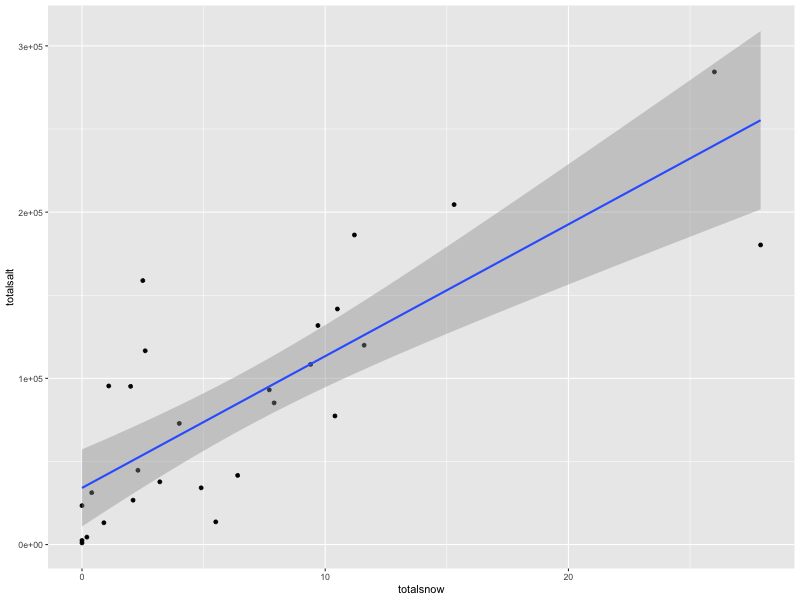

In [19]:
%%R -w 800 -h 600

ggplot(df_monthly_combined, aes(x=totalsnow, y=totalsalt)) +
    geom_point() + 
    geom_smooth(method='lm', formula= y~x)

In [20]:
%%R

model <- lm(totalsalt ~ totalsnow, data=df_monthly_combined)

summary(model)


Call:
lm(formula = totalsalt ~ totalsnow, data = df_monthly_combined)

Residuals:
   Min     1Q Median     3Q    Max 
-75009 -31271  -6865  29348 104934 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    34062      11270   3.022  0.00558 ** 
totalsnow       7928       1165   6.807 3.18e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 43420 on 26 degrees of freedom
Multiple R-squared:  0.6406,	Adjusted R-squared:  0.6267 
F-statistic: 46.33 on 1 and 26 DF,  p-value: 3.177e-07



### What can I learn from this statistical test?

- The P-value is very small. It means that we have relatively high confidence that there is relation between the depth of snowfall and the tons of salt dispensed.
- For every 1 more inches of snow in the city, our model expects NYC to dispense 7928 more tons of salt.

### What can I NOT learn from this statistical test?

- The R-Squared shows that about 64% of the data can be explained by this best-fit line, which shows that we are not confident that this model is the best to represent the relationship between the two quantities.

### Further reporting questions to answer

- How about we narrow down the time bucket to days? Will the city dispensing salt a day before or after the snowfall ruin the relationship?
- What about snow forecast and salt dispense? Does forecasting more snow make the city dispensing higher tons of salt?